In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.vision.models.xresnet import xresnet50

import pandas as pd

In [3]:
images_path = '../data/resized_images'
labels_path = '../data/resized_labels.csv'

In [4]:
y = pd.read_csv(labels_path, index_col='filename')

In [5]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(y.loc[filename])[0::2], list(y.loc[filename])[1::2])
    return tensor(list(zipped))

pet_block = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y = lambda x: get_y_func(x),
    splitter=RandomSplitter()
)

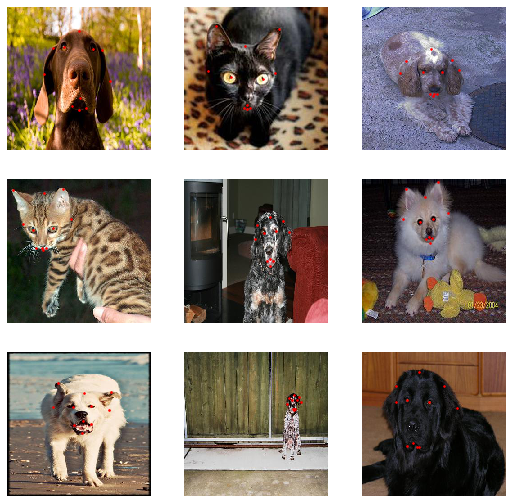

In [6]:
pet_dataloaders = pet_block.dataloaders(
    images_path,
    bs=32,
    item_tfms = [Resize(320, method='squish')],
    batch_tfms=[
        *aug_transforms(
            max_rotate=30, 
            max_zoom=1.5, 
            max_lighting=0.5, 
            max_warp=0.4, 
            p_affine=1., 
            p_lighting=1., 
#             size=(160,160)
        ),
        Normalize.from_stats(*imagenet_stats),
    ]
)
pet_dataloaders.c = pet_dataloaders.train.after_item.c
pet_dataloaders.show_batch()

In [7]:
body = create_body(xresnet50, pretrained=True)
head = create_head(nf=4096, n_out=22)
arch = nn.Sequential(body, head)

In [8]:
def _xresnet_split(m): 
    return L(m[0][:6], m[0][6:], m[1:]).map(params)

In [9]:
apply_init(arch[1], nn.init.kaiming_normal_)

In [10]:
learn = Learner(
    pet_dataloaders, 
    arch, 
    loss_func=MSELossFlat(), 
    splitter=_xresnet_split,
    opt_func=ranger
)
learn.path = Path('..')

In [11]:
learn.freeze()

epoch,train_loss,valid_loss,time
0,1.767470,0.382163,03:05
1,0.374741,0.110844,02:45
2,0.125700,0.074393,02:45
3,0.086399,0.065319,02:45
4,0.073590,0.062210,02:45


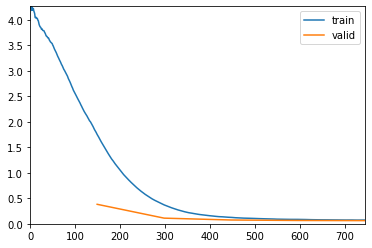

In [12]:
learn.fit_one_cycle(5, 1e-2, cbs=[ShowGraphCallback()])

In [13]:
learn.unfreeze()

epoch,train_loss,valid_loss,time
0,0.072774,0.062108,03:42
1,0.071224,0.061945,03:36
2,0.072907,0.061882,03:36
3,0.070343,0.061452,03:36
4,0.069422,0.061242,03:36
5,0.069454,0.061111,03:36
6,0.068513,0.060851,03:36
7,0.067300,0.060742,03:37
8,0.065612,0.060272,03:37
9,0.064282,0.060591,03:37


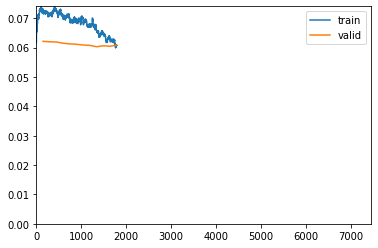

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/myenv/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ec2-user/anaconda3/envs/myenv/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ec2-user/anaconda3/envs/myenv/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ec2-user/anaconda3/envs/myenv/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/myenv/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ec2-user/anaconda3/envs/myenv/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ec2-user/anaconda3/e

IndexError: list index out of range

In [14]:
learn.fit_one_cycle(50, 1e-4, cbs=[SaveModelCallback(), ShowGraphCallback()])

In [16]:
learn = learn.load('model')

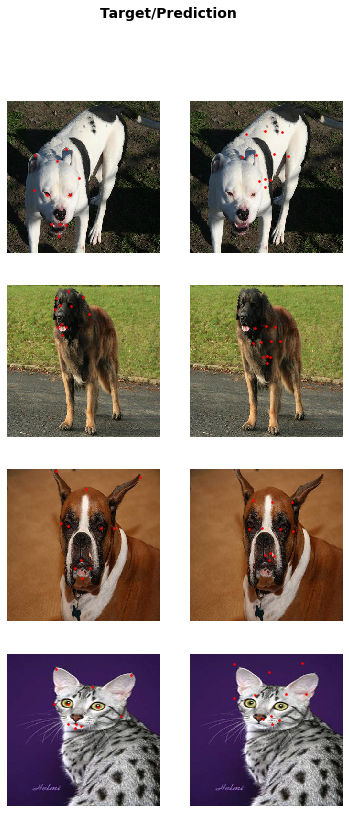

In [17]:
learn.show_results(max_n=10)

In [18]:
# learn.predict(pet_dataloaders.train_ds.items[0])

In [24]:
# learn.summary()